In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 

### Capital Bikeshare Data
https://ride.capitalbikeshare.com/system-data

We deal with data from Jan to Apr in 2022

In [2]:
# read csv files
df_Jan=pd.read_csv('Data/202201-capitalbikeshare-tripdata.csv')
df_Feb=pd.read_csv('Data/202202-capitalbikeshare-tripdata.csv')
df_Mar=pd.read_csv('Data/202203-capitalbikeshare-tripdata.csv')
df_Apr=pd.read_csv('Data/202204-capitalbikeshare-tripdata.csv')

In [3]:
# concat data
df=pd.concat([df_Jan,df_Feb,df_Mar,df_Apr])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828621 entries, 0 to 310434
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             828621 non-null  object 
 1   rideable_type       828621 non-null  object 
 2   started_at          828621 non-null  object 
 3   ended_at            828621 non-null  object 
 4   start_station_name  792027 non-null  object 
 5   start_station_id    792027 non-null  float64
 6   end_station_name    786251 non-null  object 
 7   end_station_id      786251 non-null  float64
 8   start_lat           828621 non-null  float64
 9   start_lng           828621 non-null  float64
 10  end_lat             827170 non-null  float64
 11  end_lng             827170 non-null  float64
 12  member_casual       828621 non-null  object 
dtypes: float64(6), object(7)
memory usage: 88.5+ MB


In [4]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member


### Be careful when dealing with time and date

In [5]:
# Transform time to date ONLY
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,started_at_date,ended_at_date
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member,2022-01-06,2022-01-06
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member,2022-01-31,2022-01-31
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member,2022-01-07,2022-01-07
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual,2022-01-27,2022-01-27
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member,2022-01-07,2022-01-07


## For demonstration, we consider GWSB station "22nd & H St NW"
### Students will work with '21st & I St NW' and '21st St & Pennsylvania Ave NW' instead.

### Count daily pickups

In [7]:
# Group and get pickup occurrence for 22nd & H St NW
df_sub1 = df[df['start_station_name']=="21st & I St NW"]
df_grp1 = df_sub1.groupby(['started_at_date','start_station_name']).size()
df_pu=df_grp1.reset_index(name = "pu_ct")
df_pu

,started_at_date,start_station_name,pu_ct
0,2022-01-01,21st & I St NW,7
1,2022-01-02,21st & I St NW,5
2,2022-01-04,21st & I St NW,2
3,2022-01-05,21st & I St NW,5
4,2022-01-06,21st & I St NW,10
...,...,...,...
113,2022-04-26,21st & I St NW,49
114,2022-04-27,21st & I St NW,67
115,2022-04-28,21st & I St NW,58
116,2022-04-29,21st & I St NW,69


### Count daily dropoffs

In [8]:
# Group and get drop off occurrence for 22nd & H St NW
df_sub2 = df[df['end_station_name']=="21st & I St NW"]
df_grp2 = df_sub2.groupby(['ended_at_date','end_station_name']).size()
df_do=df_grp2.reset_index(name = "do_ct")
df_do

,ended_at_date,end_station_name,do_ct
0,2022-01-01,21st & I St NW,5
1,2022-01-02,21st & I St NW,5
2,2022-01-04,21st & I St NW,6
3,2022-01-05,21st & I St NW,5
4,2022-01-06,21st & I St NW,10
...,...,...,...
113,2022-04-26,21st & I St NW,67
114,2022-04-27,21st & I St NW,53
115,2022-04-28,21st & I St NW,57
116,2022-04-29,21st & I St NW,63


### Visualize pickups and dropoffs

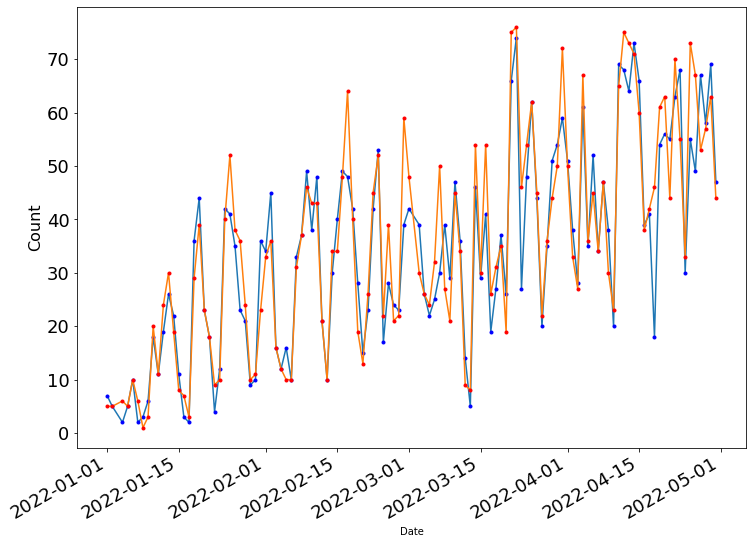

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( df_pu['started_at_date'], df_pu['pu_ct'],linestyle = 'solid',markeredgecolor = 'blue',markerfacecolor = 'blue', markersize = 3)
ax1.plot_date( df_do['ended_at_date'], df_do['do_ct'],linestyle = 'solid',markeredgecolor = 'red',markerfacecolor = 'red', markersize = 3)

ax1.set_xlabel('Date',fontsize=10)
ax1.set_ylabel('Count',fontsize=16)
plt.gcf().autofmt_xdate()

plt.tick_params(labelsize=18)
plt.show()  

## Weather Data

In [10]:
df_weather = pd.read_csv('Data/DC Weather 2022-01-01 to 2022-12-31.csv')

df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Washington,DC,USA",2022-01-01,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,...,0.6,0,NaN,2022-01-01T07:26:53,2022-01-01T16:56:53,0.99,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,A..."
1,"Washington,DC,USA",2022-01-02,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,...,1.7,1,NaN,2022-01-02T07:27:00,2022-01-02T16:57:43,1.00,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."
2,"Washington,DC,USA",2022-01-03,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,...,0.0,0,NaN,2022-01-03T07:27:05,2022-01-03T16:58:34,0.00,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,snow,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,A..."
3,"Washington,DC,USA",2022-01-04,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,...,5.4,6,NaN,2022-01-04T07:27:07,2022-01-04T16:59:27,0.02,Clear,Clear conditions throughout the day.,snow,"KDCA,72405013743,72403793728,D6279,F0198,KADW,..."
4,"Washington,DC,USA",2022-01-05,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,...,2.2,1,NaN,2022-01-05T07:27:08,2022-01-05T17:00:21,0.05,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."


## Check missing values

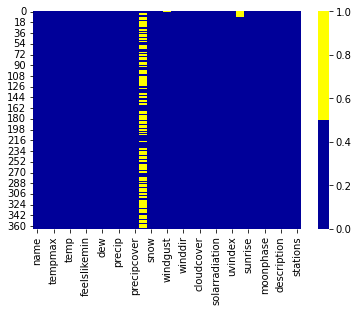

In [11]:
# Date time format 
df_weather['datetime'] = pd.to_datetime(df_weather['datetime']).dt.date

# Use sns heatmap to see whats are the null values.
coln = df_weather.columns[:df_weather.shape[1]]  
colors = ['#000099','#ffff00'] # specify the colors - yellow is missing. blue is not missing.
sns.heatmap(df_weather[coln].isnull(), cmap = sns.color_palette(colors))
plt.show()

## Drop variables of your choice

In [12]:
# Drop unnecessary variables
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])

## Prepare X and y: Merge weather data with trip data

In [13]:
# Merge with weather data and remove dates and station name

df_m_pu = df_pu.merge(df_weather, left_on='started_at_date', right_on='datetime') 
df_m_pu = df_m_pu.drop(columns=['started_at_date','start_station_name','datetime'])
df_m_do = df_do.merge(df_weather, left_on='ended_at_date', right_on='datetime') 
df_m_do = df_m_do.drop(columns=['ended_at_date','end_station_name','datetime'])

In [14]:
df_m_pu.head()

,pu_ct,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,7,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,...,11.4,190.2,1007.2,99.5,6.2,21.4,0.6,0,0.99,rain
1,5,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,...,18.9,290.7,1006.6,91.6,9.6,47.3,1.7,1,1.00,rain
2,2,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,...,14.1,192.1,1029.7,18.7,9.9,153.2,5.4,6,0.02,snow
3,5,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,...,13.6,195.2,1014.5,82.6,9.9,63.5,2.2,1,0.05,partly-cloudy-day
4,10,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,...,12.9,16.0,1012.7,88.1,9.9,145.6,5.3,4,0.09,snow


# Demo: train linear models

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [16]:
# pickup
y = df_m_pu['pu_ct']
X = df_m_pu.drop('pu_ct',axis=1)
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
0,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,100,...,99.5,6.2,21.4,0.6,0,0.99,0,1,0,0
1,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,100,...,91.6,9.6,47.3,1.7,1,1.00,0,1,0,0
2,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,0,...,18.7,9.9,153.2,5.4,6,0.02,0,0,1,0
3,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,0,...,82.6,9.9,63.5,2.2,1,0.05,1,0,0,0
4,42.9,36.9,39.8,40.6,29.5,35.3,24.2,55.0,0.000,0,...,88.1,9.9,145.6,5.3,4,0.09,0,0,1,0


In [17]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.4, random_state = 200)

## Linear Regression

In [18]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train) 
y_pred = linear_regressor.predict(X_test)

In [19]:
print(pd.Series(linear_regressor.coef_.flatten(), index=X_train.columns))

tempmax                   0.431837
tempmin                   0.448190
temp                     -1.871509
feelslikemax             -0.538638
feelslikemin             -0.896445
feelslike                 1.318472
dew                       2.196419
humidity                 -1.363480
precip                    4.108471
precipprob                0.015612
precipcover              -0.207099
snow                     -2.908279
snowdepth                 0.065122
windspeed                -1.213763
winddir                   0.032159
sealevelpressure          0.162454
cloudcover                0.101044
visibility               -0.653260
solarradiation           -0.249588
solarenergy               3.458863
uvindex                  -0.331106
moonphase                 4.358135
icon_partly-cloudy-day   -1.570322
icon_rain                -3.090264
icon_snow                 4.660585
icon_wind                 0.000000
dtype: float64


In [20]:
mse_lr = round(mean_squared_error(y_test, y_pred),3)
print(f"MSE is {mse_lr}")

MSE is 213.572


## LASSO CV

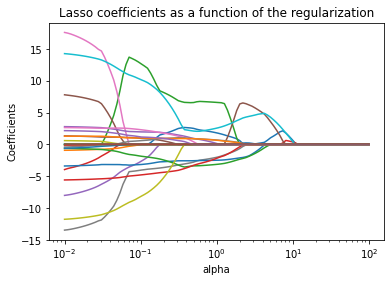

In [21]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
# plt.legend(list(X_train.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

In [22]:
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X_train), y_train)

print('The best alpha from LassoCV:', lassocv.alpha_)

The best alpha from LassoCV: 0.7924828983539177


In [23]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   2.061753
tempmin                   0.000000
temp                      6.690140
feelslikemax              0.000000
feelslikemin              0.000000
feelslike                 0.000000
dew                       0.000000
humidity                 -2.245071
precip                   -0.000000
precipprob               -0.000000
precipcover              -2.495638
snow                      0.000000
snowdepth                -3.228062
windspeed                -2.590788
winddir                   0.481611
sealevelpressure          0.000000
cloudcover                0.000000
visibility                0.790024
solarradiation           -0.000000
solarenergy               2.318058
uvindex                   0.000000
moonphase                 0.765663
icon_partly-cloudy-day    0.000000
icon_rain                -0.000000
icon_snow                 0.000000
icon_wind                 0.000000
dtype: float64


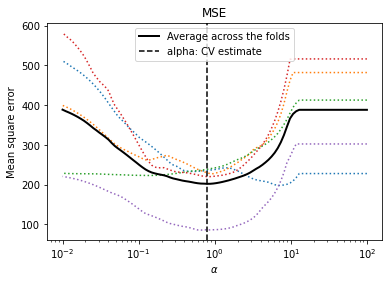

In [24]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [25]:
y_pred=lasso.predict(scale(X_test.values))
mse_lasso = round(mean_squared_error(y_test, y_pred),3)
print(f"MSE is {mse_lasso}")

MSE is 143.928


## Ridge CV

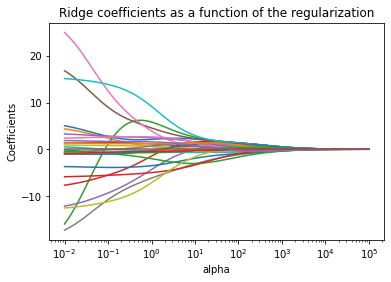

In [26]:
alphas = 10**np.linspace(-2,5,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X_train), y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')


plt.title('Ridge coefficients as a function of the regularization');

In [27]:
# standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [28]:
# set a large alpha to get smaller coefficients
ridge = Ridge(alpha=1000) 
ridge.fit(scaler.transform(X_train), y_train)

print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   0.518914
tempmin                   0.417278
temp                      0.501468
feelslikemax              0.516175
feelslikemin              0.434726
feelslike                 0.505465
dew                       0.256249
humidity                 -0.323599
precip                   -0.318611
precipprob               -0.249697
precipcover              -0.360155
snow                     -0.279665
snowdepth                -0.403603
windspeed                -0.159882
winddir                   0.080501
sealevelpressure          0.042812
cloudcover               -0.162258
visibility                0.296259
solarradiation            0.353997
solarenergy               0.496237
uvindex                   0.468611
moonphase                 0.205383
icon_partly-cloudy-day    0.286303
icon_rain                -0.068904
icon_snow                -0.305114
icon_wind                 0.000000
dtype: float64


In [29]:
# find the best alpha via CV with selected scoring metric
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

print('The best alpha from RidgeCV:', ridgecv.alpha_)

The best alpha from RidgeCV: 65.79332246575676


In [30]:
# with the best alpha
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X_train), y_train)
print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   1.528190
tempmin                   0.953324
temp                      1.504584
feelslikemax              1.443118
feelslikemin              0.936046
feelslike                 1.482091
dew                       0.544671
humidity                 -1.423951
precip                   -0.710783
precipprob               -0.583724
precipcover              -1.057026
snow                     -0.253508
snowdepth                -2.001615
windspeed                -1.306707
winddir                   0.559955
sealevelpressure          0.280232
cloudcover                0.089480
visibility                1.014818
solarradiation            0.228772
solarenergy               1.461669
uvindex                   1.220681
moonphase                 1.081979
icon_partly-cloudy-day    0.336282
icon_rain                -0.206719
icon_snow                -0.204678
icon_wind                 0.000000
dtype: float64


In [31]:
y_pred=ridge.predict(scale(X_test.values))
mse_ridge = round(mean_squared_error(y_test, y_pred),3)
print(f"MSE is {mse_ridge}")

MSE is 147.98


## Elastic net

In [32]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

ENcv = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv.fit(scale(X_train), y_train)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

The best alpha from ElasticNetCV: 0.8441537223475757


In [33]:
# with the best alpha
#lasso.set_params(alpha=lassocv.alpha_)
#lasso.fit(scale(X_train), y_train)


EN=ElasticNet()
EN.set_params(alpha=ENcv.alpha_)
EN.fit(scale(X_train), y_train)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   1.787805
tempmin                   0.732949
temp                      1.822107
feelslikemax              1.605643
feelslikemin              0.684583
feelslike                 1.779751
dew                       0.070541
humidity                 -1.589035
precip                   -0.578261
precipprob               -0.506038
precipcover              -1.276274
snow                     -0.000000
snowdepth                -2.460448
windspeed                -1.725519
winddir                   0.483840
sealevelpressure          0.000000
cloudcover                0.000000
visibility                1.080337
solarradiation            0.000000
solarenergy               1.708672
uvindex                   1.202641
moonphase                 1.064203
icon_partly-cloudy-day    0.085965
icon_rain                -0.000000
icon_snow                -0.000000
icon_wind                 0.000000
dtype: float64


In [34]:
y_pred = EN.predict(scale(X_test.values))
mse_EN = round(mean_squared_error(y_test, y_pred), 3)
print(f"Test MSE for ElasticNet is {mse_EN}")

Test MSE for ElasticNet is 144.573


## KNN

In [35]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
mse_train = [-1]*30
mse_test = [-1]*30
for K in range(30):
    model = neighbors.KNeighborsRegressor(n_neighbors = K+1)
    model.fit(X_train, y_train)  #fit the model
    mse_train[K] = mean_squared_error(y_train, model.predict(X_train))
    mse_test[K] = mean_squared_error(y_test, model.predict(X_test)) 


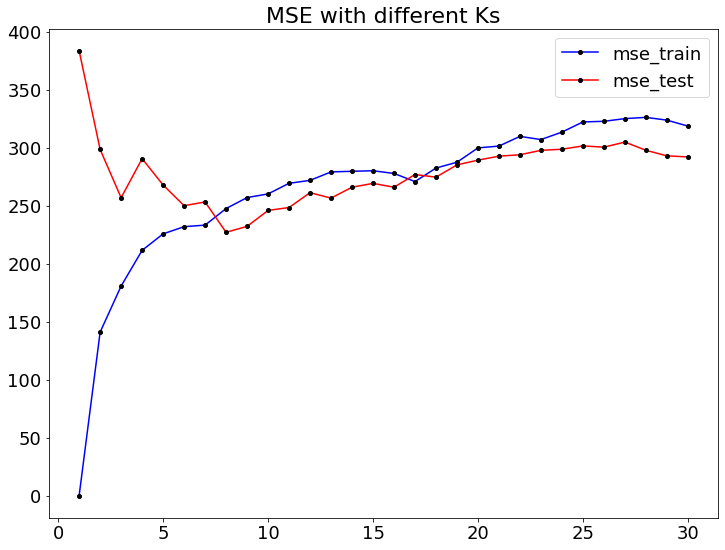

In [36]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(30)+1, mse_train,  color = 'blue', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(30)+1, mse_test,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

In [37]:
# optimal k
np.argmin(mse_test)+1

8

In [38]:
# optimal MSE
min(mse_test)

226.99739583333334

### KNN CV

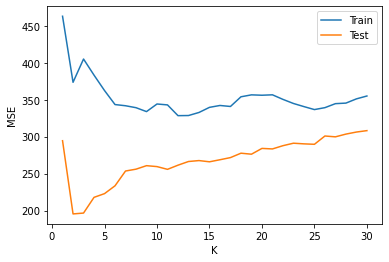

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

mse_train = []
mse_test = []
for K in range(1, 31):
    knn = KNeighborsRegressor(n_neighbors=K)
    scores_train = -cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    scores_test = -cross_val_score(knn, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
    mse_train.append(np.mean(scores_train))
    mse_test.append(np.mean(scores_test))

plt.plot(range(1, 31), mse_train, label='Train')
plt.plot(range(1, 31), mse_test, label='Test')
plt.xlabel('K')
plt.ylabel('MSE')
plt.legend()
plt.show()

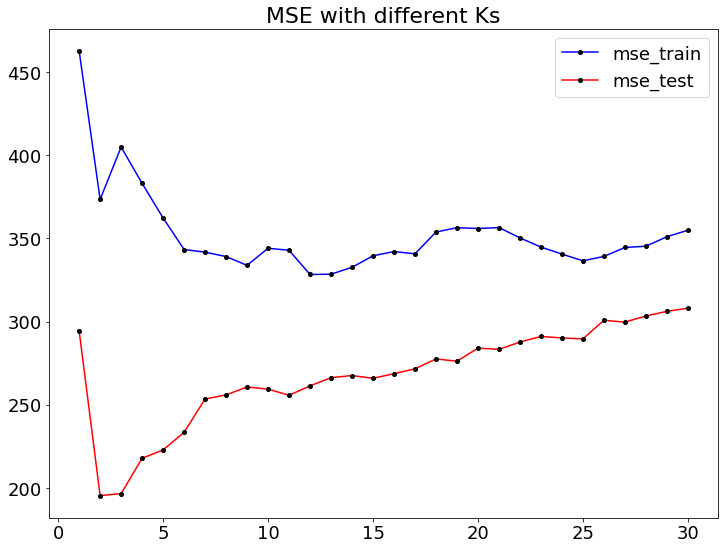

In [40]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(30)+1, mse_train,  color = 'blue', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(30)+1, mse_test,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

In [41]:
# optimal k
np.argmin(mse_test)+1

2

In [42]:
# optimal MSE
min(mse_test)

195.38000000000002

## You will try other methods (e.g., KNN) and tune hyperparameters when necessary

In [43]:
import pandas as pd

# Define data
mse_values = [mse_lr, min(mse_test), mse_lasso, mse_ridge, mse_EN]
hyperparameters = [
    'N/A',
    'k = 2',
    lassocv.alpha_,
    ridgecv.alpha_,
    ENcv.alpha_
]
model_names = ['Linear Regression', 'KNN CV', 'Lasso CV', 'Ridge CV', 'Elastic Net CV']

# Create table
df = pd.DataFrame({
    'Model': model_names,
    'MSE': mse_values,
    'Hyperparameters': hyperparameters
})

# Print table
print(df)                                                   

               Model      MSE Hyperparameters
0  Linear Regression  213.572             N/A
1             KNN CV  195.380           k = 2
2           Lasso CV  143.928        0.792483
3           Ridge CV  147.980       65.793322
4     Elastic Net CV  144.573        0.844154


### Scenario 1

In [44]:
X_test.iloc[[1]]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
66,51.8,36.5,44.5,51.8,30.0,41.9,31.6,63.1,0.0,0,...,87.6,9.6,100.8,8.6,5,0.25,1,0,0,0


In [45]:
scaler.transform(X_test.iloc[[1]])

array([[-0.31429148, -0.14236333, -0.16762738, -0.17148361, -0.1570302 ,
        -0.07539168,  0.04788074,  0.38650552, -0.46071197, -0.74535599,
        -0.57768727, -0.33973241, -0.33383682, -0.87540904, -1.48067079,
         0.20104645,  0.85839154,  0.30669374,  0.12146072,  0.18644612,
         0.065861  , -0.82550601,  0.8660254 , -0.61036794, -0.43178777,
         0.        ]])

In [46]:
y_pred1 = lasso.predict(scaler.transform(X_test.iloc[[1]]))
print(y_pred1)


[34.35091925]


In [47]:
y_test.iloc[[1]]

66    47
Name: pu_ct, dtype: int64

### Scenario 2

In [48]:
X_test.iloc[[2]]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
34,34.9,26.6,31.2,24.7,17.2,20.8,14.2,49.7,0.0,0,...,45.2,9.9,104.9,9.2,6,0.11,1,0,0,0


In [49]:
y_pred2 = lasso.predict(scaler.transform(X_test.iloc[[2]]))
print(y_pred2)

[22.00922778]


In [50]:
y_test.iloc[[2]]

34    16
Name: pu_ct, dtype: int64